# Arima

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [72]:
df = pd.read_csv(
    "./data/daily_revenue.csv", 
    parse_dates=True, 
    index_col="date",
    dayfirst=True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [73]:
df.index.freq = "D"

In [74]:
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   revenue        1795 non-null   str  
 1   discount_rate  1795 non-null   str  
 2   coupon_rate    1795 non-null   str  
dtypes: str(3)
memory usage: 56.1 KB


In [75]:
df["revenue"] = df["revenue"].apply(lambda x: x.replace(",", "")).astype(float)

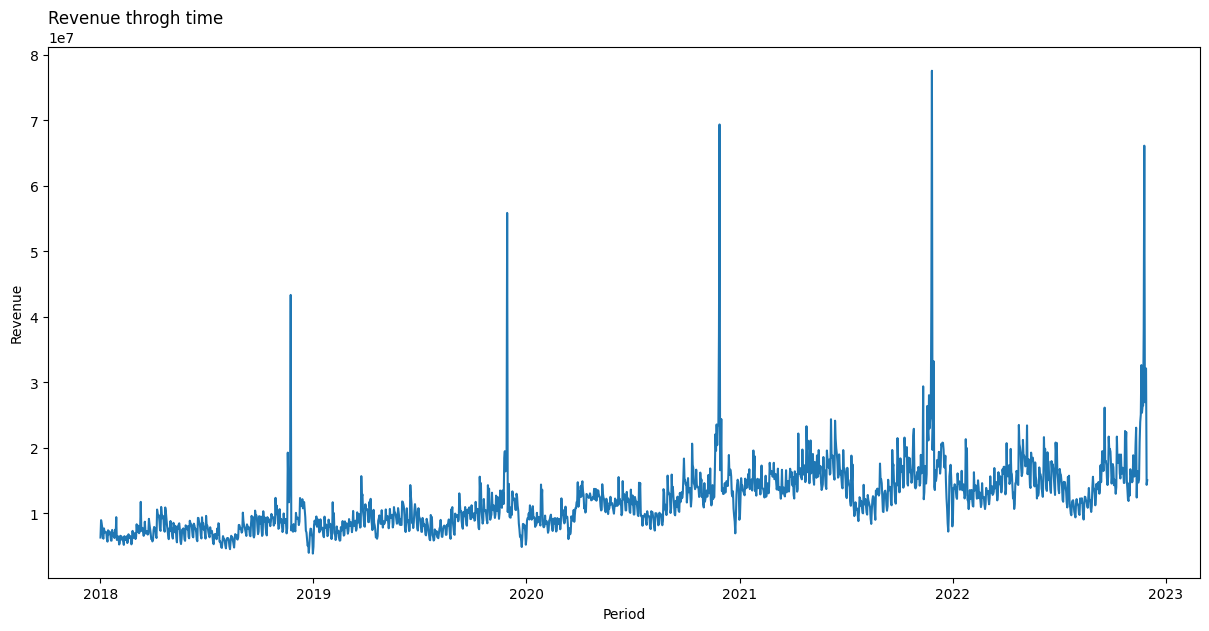

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(df["revenue"])
plt.tight_layout()
plt.title("Revenue throgh time", loc="left")
plt.xlabel("Period")
plt.ylabel("Revenue")
plt.show()

### Proving Seasonality Model

In [77]:
add_curve = seasonal_decompose(df["revenue"], model="add")
mul_curve = seasonal_decompose(df["revenue"], model="mul")

add_std = add_curve.resid.dropna().std()
mul_std = mul_curve.resid.dropna().std()

print("Additive Standard Deviation: ", add_std)
print("Multiplicative Standard Deviation: ", mul_std)

Additive Standard Deviation:  2433620.7687852536
Multiplicative Standard Deviation:  0.1285596370807388


The seasonlity of the curve is proved to be **Multiplicative**

obs: The lower values proves itself

### Seasonal Decomposition

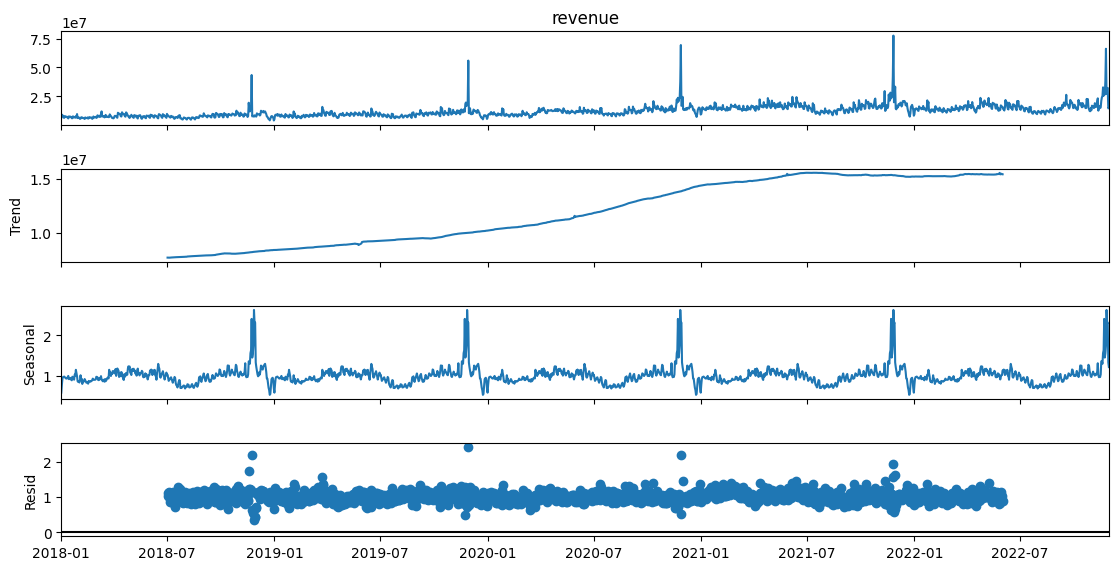

In [78]:
decomposition = seasonal_decompose(df["revenue"], model="mul", period=365)

fig = decomposition.plot()
fig.set_size_inches((12,6))
plt.show()

### Autocorrelation and Partial Autocorrelation

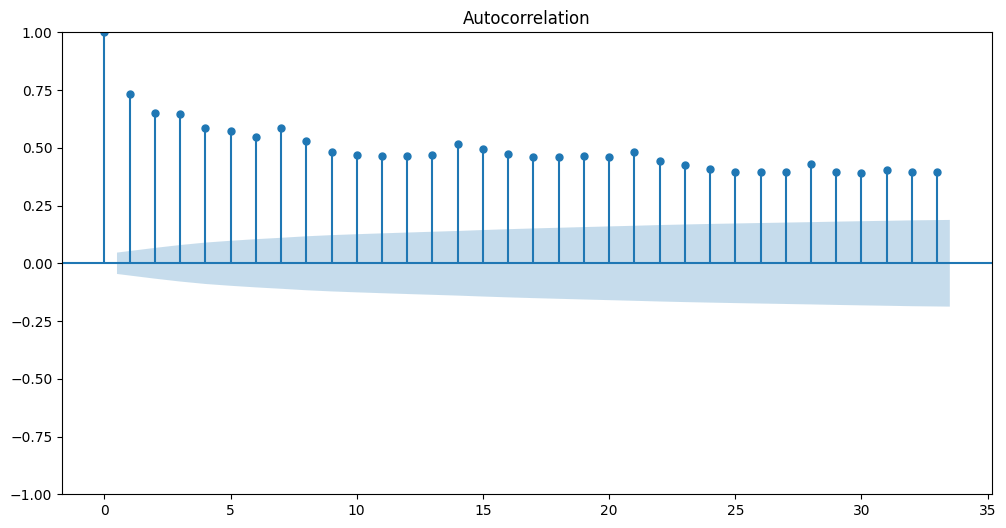

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(x=df["revenue"], ax=ax)
plt.show()

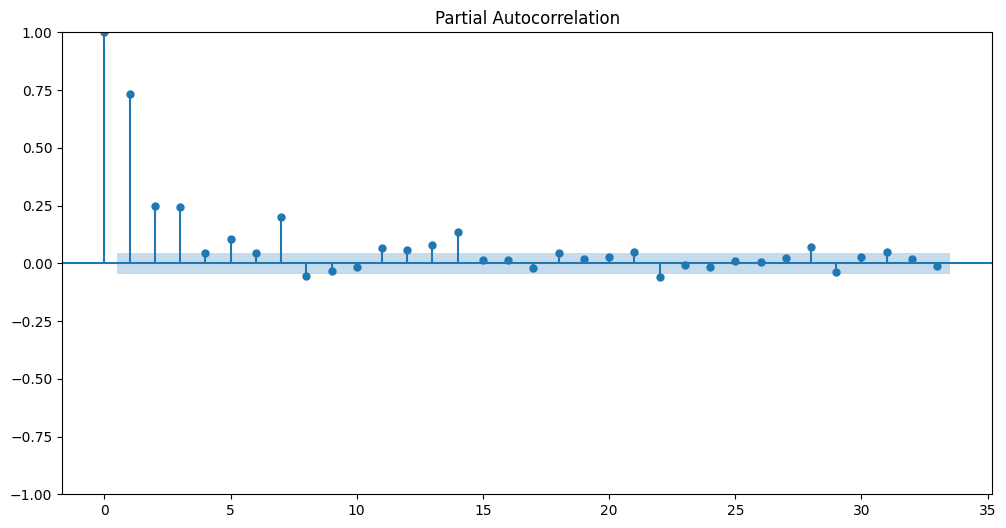

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(x=df["revenue"], ax=ax)
plt.show()

### Stationarity

In [81]:
def stationarity_information(x: pd.Series):
    adf_test = adfuller(x)

    p_value = round(adf_test[1], 5)
    if p_value > 0.05:
        print(f"The time series has a stationarity p-value of: {p_value}. Time Series IS NOT STATIONARY")
    else:
        print(f"The time series has a stationarity p-value of: {p_value}. Time Series IS STATIONARY")

In [82]:
stationarity_information(df["revenue"])

The time series has a stationarity p-value of: 0.1019. Time Series IS NOT STATIONARY


### Differencing the data

In [83]:
df["revenue_diff"] = df["revenue"].diff()
df = df.dropna()

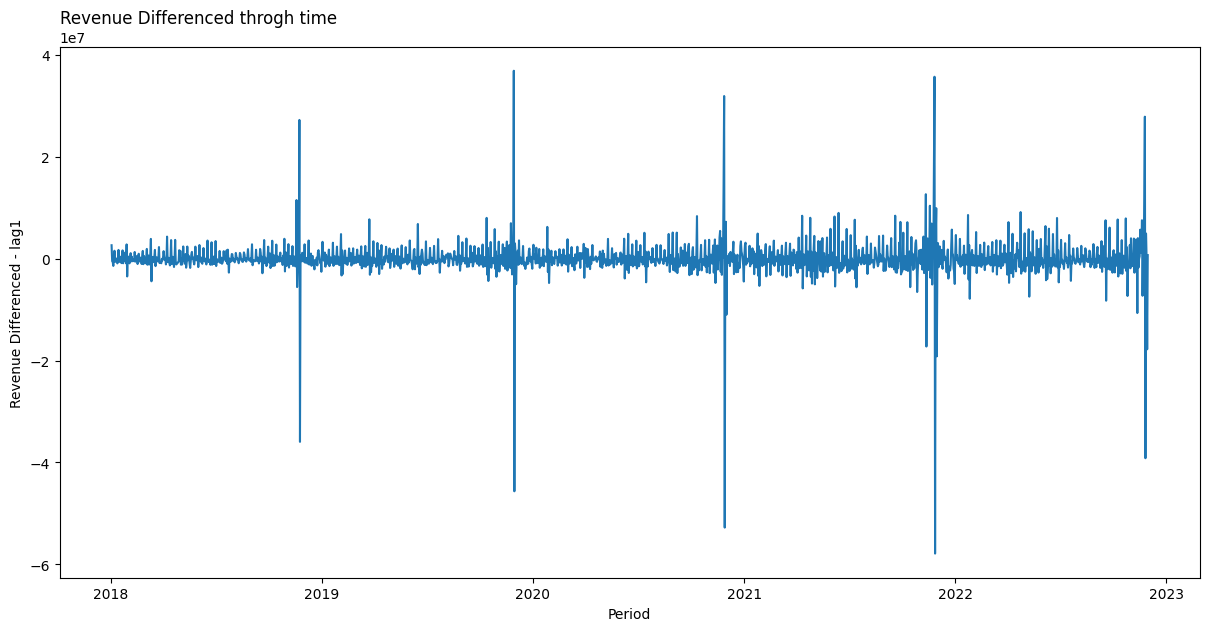

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(df["revenue_diff"])
plt.tight_layout()
plt.title("Revenue Differenced throgh time", loc="left")
plt.xlabel("Period")
plt.ylabel("Revenue Differenced - lag1")
plt.show()

In [85]:
stationarity_information(df["revenue_diff"])

The time series has a stationarity p-value of: 0.0. Time Series IS STATIONARY


### Splitting data into **Train** and **Test**

In [86]:
periods = 30
train = df[:-periods]
test = df[-periods:]

### Tools

In [91]:
def measuring_predictions(y_true: pd.Series, y_pred: pd.Series):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    accuracy = 1 - mape

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")
    print(f"Model's Accuracy: {accuracy * 100:.2f}%")

In [92]:
def model_assessment(train, test, predictions, chart_title: None):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Training Data")
    plt.plot(test, label="Testing Data")
    plt.plot(predictions, label="Prediction Data", ls="--")
    plt.title(chart_title, loc="left")
    plt.xlabel("Periods")
    plt.ylabel("Complaints")
    plt.legend()
    plt.tight_layout()
    plt.show()

## ARIMA

In [87]:
# Creating ARIMA model
# In the case I'll be using a SARIMAX class, but the parameters configuration will create an ARIMA

arima_model = SARIMAX(
    endog=train["revenue"],
    order=(3, 1 ,1), # p, d, q (AR, I, MA) # AR=3, por que no PACF, o terceiro dia foi o último com grande autocorrelação
    seasonal_order=(0, 0, 0, 0)
).fit()

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                 1764
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -28811.913
Date:                Sun, 15 Feb 2026   AIC                          57633.826
Time:                        20:52:50   BIC                          57661.199
Sample:                    01-02-2018   HQIC                         57643.941
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3557      0.014     24.681      0.000       0.327       0.384
ar.L2          0.0242      0.020      1.224      0.221      -0.015       0.063
ar.L3          0.1274      0.022      5.801      0.0

In [88]:
# Predict with ARIMA model

arima_results = arima_model.forecast(steps=periods)

In [94]:
measuring_predictions(test["revenue"], arima_results)

Mean Absolute Error: 7276547.96
Root Mean Squared Error: 12375215.42
Mean Absolute Percentage Error: 24.18%
Model's Accuracy: 75.82%


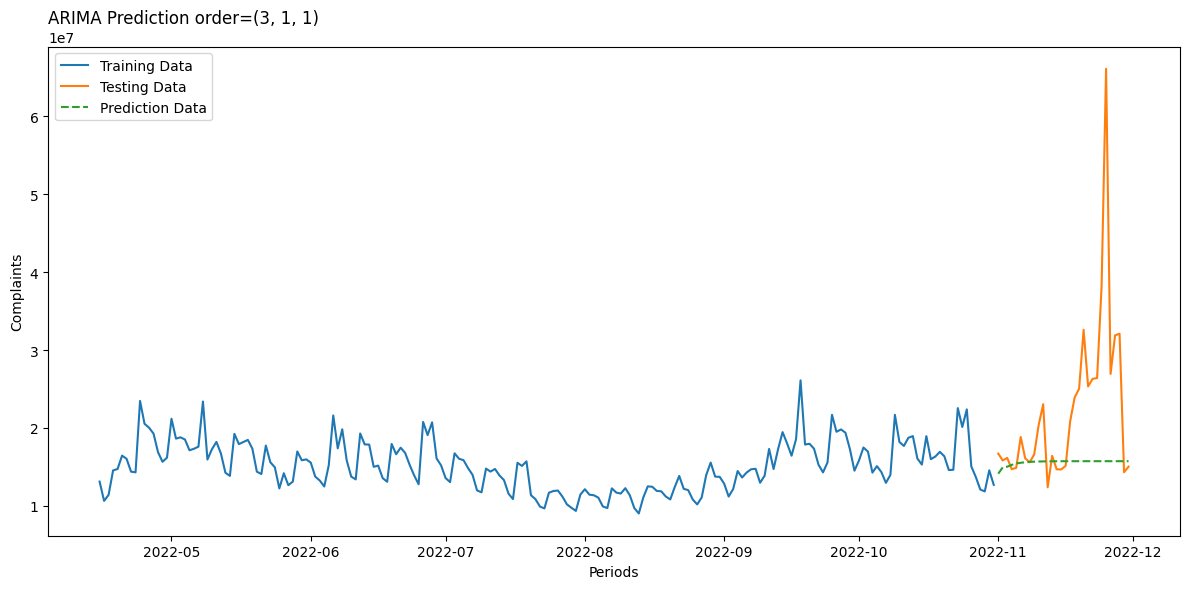

In [98]:
model_assessment(train[-200:]["revenue"], test[-200:]["revenue"], arima_results, "ARIMA Prediction order=(3, 1, 1)")